In [1]:
import pandas as pd
import sklearn
from hydra import initialize, compose
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
with initialize(version_base=None, config_path="../config/"):
    cfg = compose(config_name='main')
    
df = pd.read_csv(f"../{cfg.data.processed}")

results = pd.DataFrame()

def evaluate_and_add_to_dataframe(model, X_test, y_test, dataframe):
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted') 

    best_params = model.best_params_

    results = {
        'Normalization': 'Stematized Text',
        'Test Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        **best_params
    }

    results_list = [results]    
    results_df = pd.DataFrame(results_list, index=['Decision Tree'])
        
    return pd.concat([dataframe, results_df])

In [3]:
y = df.encoded_sentiment
X = df.stematized_text
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

pipeline_dt = Pipeline([
    ('count_vec', CountVectorizer()),
    ('DT', DecisionTreeClassifier())
])
dt_param_grid = [{
    'count_vec__ngram_range': [(1, 1)],
    'count_vec__binary': [True],
    'count_vec__stop_words': [None],
}]
dt_grid_search = GridSearchCV(estimator=pipeline_dt,
        param_grid=dt_param_grid,
        scoring='accuracy',
        cv=3)

dt = dt_grid_search.fit(X_train, y_train)
results = evaluate_and_add_to_dataframe(dt, X_test, y_test, results)
best_dt_model = dt_grid_search.best_estimator_.named_steps['DT']
count_vectorizer = dt_grid_search.best_estimator_.named_steps['count_vec']
feature_names = count_vectorizer.get_feature_names_out()

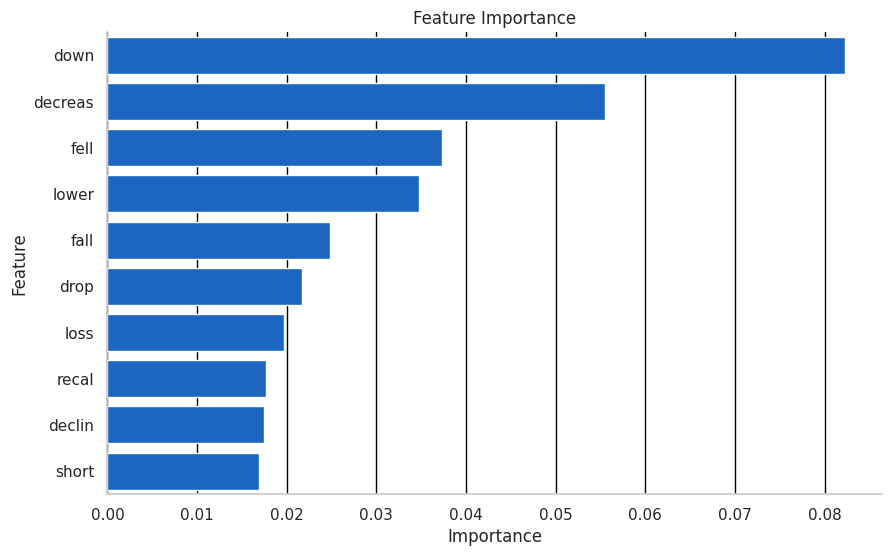

In [4]:
def plot_feature_importance(model, feature_names):
    importances_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': model.feature_importances_
    })
    importances_df = importances_df.sort_values(by='Importance', ascending=False)
    top_importances = importances_df.head(10)

    # Defina a cor de fundo como azul
    sns.set(style="whitegrid", rc={"axes.facecolor": "white", "grid.color": "black"})

    plt.figure(figsize=(10, 6))
    
    # Barras brancas
    ax = sns.barplot(x='Importance', y='Feature', data=top_importances, color="#0063de", edgecolor='white')
    
    # Adicione a borda superior e direita do gráfico
    sns.despine()

    plt.title('Feature Importance')
    plt.show()

# Exemplo de uso da função
plot_feature_importance(best_dt_model, feature_names)

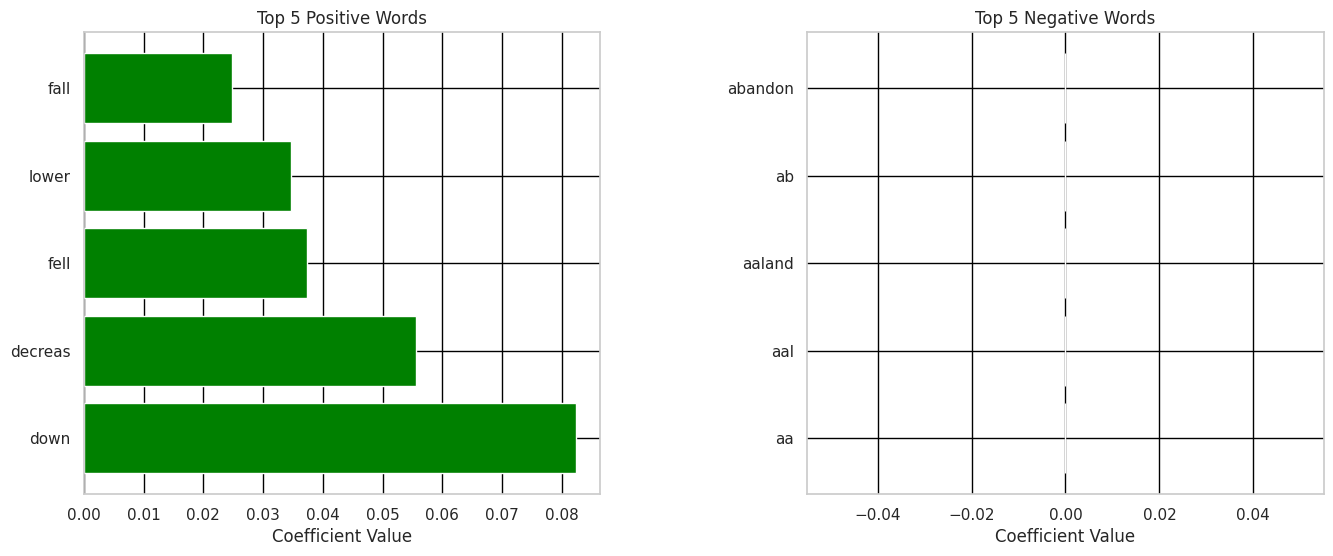

In [5]:
# Count Vectorizer
count_vectorizer = CountVectorizer(binary=True)
count_vectorizer.fit(X_train)

# Final Decision Tree Model
final_model = dt_grid_search.best_estimator_.named_steps['DT']

feature_to_coef = {
    word: coef for word, coef in zip(
        count_vectorizer.get_feature_names_out(), final_model.feature_importances_
    )
}

for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    best_positive
    
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    best_negative
    
feature_to_coef = {word: coef for word, coef in zip(count_vectorizer.get_feature_names_out(), final_model.feature_importances_)}

best_positive_words = sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:5]
best_negative_words = sorted(feature_to_coef.items(), key=lambda x: x[1])[:5]

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].barh(
    [word[0] for word in best_positive_words],
    [word[1] for word in best_positive_words],
    color="green",
)
axs[0].set_xlabel("Coefficient Value")
axs[0].set_title("Top 5 Positive Words")

axs[1].barh(
    [word[0] for word in best_negative_words],
    [word[1] for word in best_negative_words],
    color="red",
)
axs[1].set_xlabel("Coefficient Value")
axs[1].set_title("Top 5 Negative Words")

plt.subplots_adjust(wspace=0.4)

plt.show()

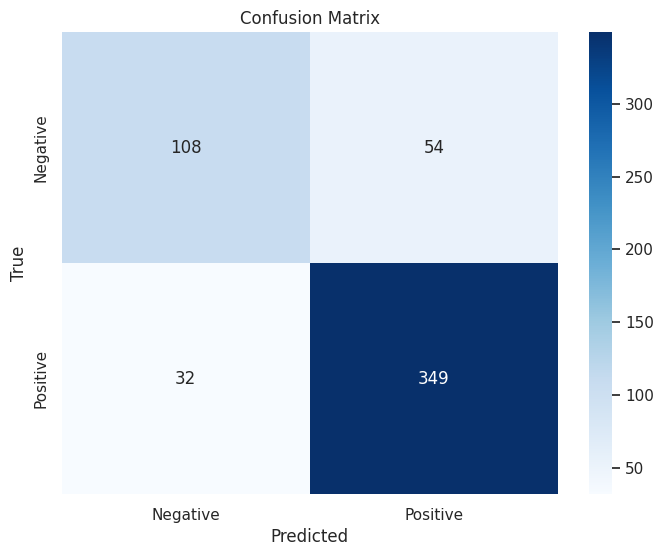

In [6]:
# Geração da matriz de confusão
conf_matrix = confusion_matrix(y_test, dt.predict(X_test))

# Visualização da matriz de confusão usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

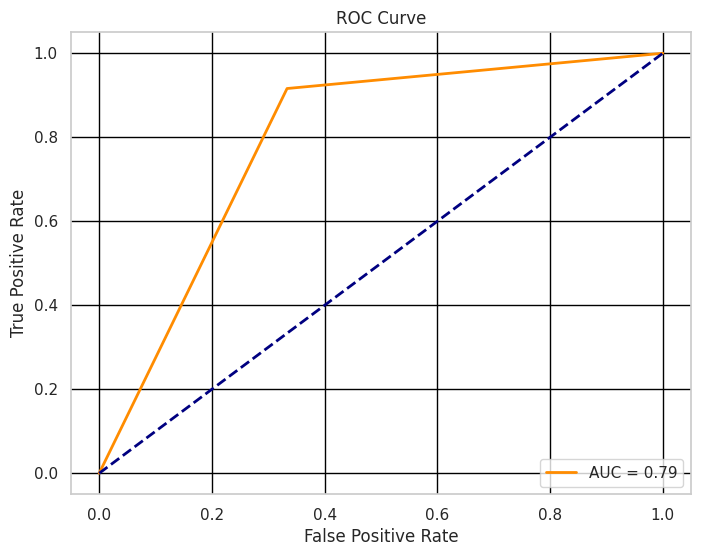

In [7]:
from sklearn.metrics import roc_curve, auc

# Calcular probabilidades de classe (apenas para classificadores que têm `predict_proba`)
y_probs = dt.predict_proba(X_test)[:, 1]

# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calcular a área sob a curva (AUC)
auc_score = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [8]:
classification_rep = classification_report(y_test, dt.predict(X_test), target_names=['Negative', 'Positive'])
print(classification_rep)

              precision    recall  f1-score   support

    Negative       0.77      0.67      0.72       162
    Positive       0.87      0.92      0.89       381

    accuracy                           0.84       543
   macro avg       0.82      0.79      0.80       543
weighted avg       0.84      0.84      0.84       543



In [9]:
from sklearn.model_selection import cross_val_score

# Exemplo de uso do cross_val_score
scores = cross_val_score(dt, X_train, y_train, cv=3, scoring='accuracy')
print("Cross-validated Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Cross-validated Accuracy: 0.84 (+/- 0.04)


In [10]:
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# # Exemplo de uso de métricas de regressão
# y_pred = dt.predict(X_test)
# print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
# print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
# print("R2 Score:", r2_score(y_test, y_pred))